Use shift-enter to execute a code block and move to the next one.

In [1]:
# 2.1 Import libraries.
import math
import sys
import os
from six.moves import xrange  # pylint: disable=redefined-builtin
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

%matplotlib inline
import matplotlib.pyplot as plt

<p>https://www.youtube.com/watch?v=Ejec3ID_h0w</p>
<p>https://www.youtube.com/watch?v=vq2nnJ4g6N0</p>

In [2]:
# 2.2 Define some constants.
# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES  = 10

# The MNIST images are always 28x28 pixels.
IS_IMAGE     = True
IMAGE_SIZE   = 28
DIMENSIONS   = (IMAGE_SIZE, IMAGE_SIZE)
ARRAY_LENGTH = IMAGE_SIZE * IMAGE_SIZE

# Batch size. Must be evenly dividable by dataset sizes.
BATCH_SIZE      = 100
EVAL_BATCH_SIZE = 1

# TF Learn rage
LEARN_RATE      = 0.001

# Number of units in hidden layers.
#HIDDEN_UNITS = [128, 32]
#HIDDEN_UNITS = [30, 60, 100, 200]
#HIDDEN1_UNITS = 128
#HIDDEN2_UNITS = 32

# Maximum number of training steps.
#MAX_STEPS = 10000

# Directory to put the training data.
TRAIN_DIR = "mnist_in"
OUT_DIR   = "mnist_out"

In [3]:
print "NUM_CLASSES    : {:12,d}" .format(NUM_CLASSES    )
print "DIMENSIONS     : {:s}"    .format(DIMENSIONS     )
print "ARRAY_LENGTH   : {:12,d}" .format(ARRAY_LENGTH   )
print "BATCH_SIZE     : {:12,d}" .format(BATCH_SIZE     )
print "EVAL_BATCH_SIZE: {:12,d}" .format(EVAL_BATCH_SIZE)
print "LEARN_RATE     : {:12.6f}".format(LEARN_RATE     )

NUM_CLASSES    :           10
DIMENSIONS     : (28, 28)
ARRAY_LENGTH   :          784
BATCH_SIZE     :          100
EVAL_BATCH_SIZE:            1
LEARN_RATE     :     0.001000


In [4]:
v = ARRAY_LENGTH
s = int(math.pow(10, int(math.log10(NUM_CLASSES))))

HIDDEN_UNITS = []

while s < (ARRAY_LENGTH/2.0):
    #s = int(math.pow(2, b))
    s *= 2
    print " # Neurons {:12,d} / {:12,d}".format(s, v),
    if s >= (2*NUM_CLASSES):
        HIDDEN_UNITS.append(s)
        print "OK"
    else:
        print

# HIDDEN_UNITS = HIDDEN_UNITS[::2]

while sum(HIDDEN_UNITS) > (ARRAY_LENGTH/1):
    print "deleting layer {:12,d}".format( HIDDEN_UNITS[-1] )
    HIDDEN_UNITS = HIDDEN_UNITS[:-1]

HIDDEN_UNITS = HIDDEN_UNITS[::-1]

# if len(HIDDEN_UNITS) > 2:
#     print "deleting layer {:12,d}".format( HIDDEN_UNITS[-1] )
#     HIDDEN_UNITS = HIDDEN_UNITS[:-1]

# HIDDEN_UNITS = [128,32]
print "HIDDEN_UNITS   : {:,d} layers with {:,d} neurons :: Values: {}".format( 
    len(HIDDEN_UNITS),
    sum(HIDDEN_UNITS),
    " ,".join(["{:,d}".format(h) for h in HIDDEN_UNITS]) )

MAX_STEPS  = sum(HIDDEN_UNITS)
MAX_STEPS *= int(0.1 / LEARN_RATE)
MAX_STEPS /= 3
MAX_STEPS *= 5
MAX_STEPS  = int(MAX_STEPS)

print "MAX_STEPS      : {:12,d}" .format(MAX_STEPS      )

assert len(HIDDEN_UNITS) > 0
assert sum(HIDDEN_UNITS) > 0
assert MAX_STEPS         > 0

 # Neurons           20 /          784 OK
 # Neurons           40 /          784 OK
 # Neurons           80 /          784 OK
 # Neurons          160 /          784 OK
 # Neurons          320 /          784 OK
 # Neurons          640 /          784 OK
deleting layer          640
HIDDEN_UNITS   : 5 layers with 620 neurons :: Values: 320 ,160 ,80 ,40 ,20
MAX_STEPS      :      103,330


In [5]:
# 2.3 Get input data: get the sets of images and labels for training, validation, and
# test on MNIST.
data_sets = read_data_sets(TRAIN_DIR, False)

Extracting mnist_in/train-images-idx3-ubyte.gz
Extracting mnist_in/train-labels-idx1-ubyte.gz
Extracting mnist_in/t10k-images-idx3-ubyte.gz
Extracting mnist_in/t10k-labels-idx1-ubyte.gz


In [6]:
# data_sets

In [7]:
HIDDENS = []
for hu in HIDDEN_UNITS:
    #               units name  weights biases pkeep, layer
    HIDDENS.append([hu,   None, None,   None,  None, None ])
# print HIDDENS

In [8]:
prefix             = "_{:.5f}".format(LEARN_RATE)
suffix             = "-{:d}"  .format(MAX_STEPS)
INFERENCE_FILE     = "inference{}.pbtxt".format(prefix)
TRAIN_FILE         = "train{}.pbtxt"    .format(prefix)
COMPLETE_FILE      = "complete{}.pbtxt" .format(prefix)
CHECKPOINT_FILE_BN = os.path.join(OUT_DIR, "checkpoint{}".format(prefix))
CHECKPOINT_FILE    ="{}{}".format(CHECKPOINT_FILE_BN, suffix)

print "INFERENCE_FILE  : {}".format(INFERENCE_FILE )
print "TRAIN_FILE      : {}".format(TRAIN_FILE     )
print "COMPLETE_FILE   : {}".format(COMPLETE_FILE  )
print "CHECKPOINT_FILE : {}".format(CHECKPOINT_FILE)

INFERENCE_FILE  : inference_0.00100.pbtxt
TRAIN_FILE      : train_0.00100.pbtxt
COMPLETE_FILE   : complete_0.00100.pbtxt
CHECKPOINT_FILE : mnist_out/checkpoint_0.00100-103330


In [9]:
# 2.4 Build inference graph.
def mnist_inference(images, hiddens, num_classes, out_dir="./", inference_file="inference.pbtxt"):
    """Build the MNIST model up to where it may be used for inference.
    Args:
        images: Images placeholder.
        hidden1_units: Size of the first hidden layer.
        hidden2_units: Size of the second hidden layer.
    Returns:
        logits: Output tensor with the computed logits.
    """

    for hidden_num, (hidden_units, hidden_name, hidden_weight, hidden_biases, hidden_pkeep, hidden_layer) in enumerate(hiddens):
        hidden_name = 'hidden{}'.format(hidden_num+1)
        
        if hidden_num == 0:
            prev_units    = ARRAY_LENGTH
            prev_layer    = images
        else:
            prev_units    = hiddens[hidden_num-1][0]
            prev_layer    = hiddens[hidden_num-1][5]
        
        with tf.name_scope(hidden_name):
            stddev = 1.0 / math.sqrt(float(prev_units))
            
            print " Adding layer {:15s} with {:12,d} -> {:12,d} neurons. stddev {:,f}".format(
                    hidden_name, prev_units, hidden_units,stddev)
            
            hidden_weight = tf.Variable(
                                    tf.truncated_normal(
                                        [prev_units, hidden_units],
                                        stddev=stddev),
                                    name='weights')
            
            hidden_biases = tf.Variable(tf.zeros([hidden_units]),
                                     name='biases')
            
#             hidden_pkeep  = tf.placeholder(tf.float32)
#             hidden_layerT = tf.nn.relu(tf.matmul(prev_layer, hidden_weight) + hidden_biases)
#             hidden_layer  = tf.nn.dropout(hidden_layerT, hidden_pkeep)
            hidden_layer        = tf.nn.relu(tf.matmul(prev_layer, hidden_weight) + hidden_biases)
    
            hiddens[hidden_num] = [ hidden_units, hidden_name, hidden_weight, hidden_biases, hidden_pkeep, hidden_layer ]

    last_hidden_units, last_hidden_name, last_hidden_weight, last_hidden_biases, hidden_pkeep, last_hidden_layer = hiddens[-1]

    # Linear
    sl_name = 'softmax_linear'
    with tf.name_scope(sl_name):
        stddev  = 1.0 / math.sqrt(float(last_hidden_units))
        
        print " Adding layer {:15s} with {:12,d} -> {:12,d} neurons. stddev {:,f}".format(
            sl_name, last_hidden_units, num_classes, stddev)
        
        weights = tf.Variable(
                                tf.truncated_normal(
                                    [last_hidden_units, num_classes],
                                    stddev=stddev),
                                name='weights')
        
        biases  = tf.Variable(tf.zeros([num_classes]), name='biases')
        
        logits  = tf.matmul(last_hidden_layer, weights) + biases
        
        hiddens.append([num_classes, sl_name, weights, biases, None, logits])

    # Uncomment the following line to see what we have constructed.
    tf.train.write_graph(tf.get_default_graph().as_graph_def(), out_dir, inference_file, as_text=True)
    
    return logits

In [10]:
# 2.5 Build training graph.
def mnist_training(logits, labels, learning_rate, out_dir="./", train_file="train.pbtxt"):
    """Build the training graph.

    Args:
        logits: Logits tensor, float - [BATCH_SIZE, NUM_CLASSES].
        labels: Labels tensor, int32 - [BATCH_SIZE], with values in the
          range [0, NUM_CLASSES).
        learning_rate: The learning rate to use for gradient descent.
    Returns:
        train_op: The Op for training.
        loss: The Op for calculating loss.
    """
    # Create an operation that calculates loss.
    labels        = tf.to_int64(labels)

    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits, labels, name='xentropy')
    
    loss          = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    
    # Create the gradient descent optimizer with the given learning rate.
    optimizer     = tf.train.GradientDescentOptimizer(learning_rate)
    
    # Create a variable to track the global step.
    global_step   = tf.Variable(0, name='global_step', trainable=False)
    
    # Use the optimizer to apply the gradients that minimize the loss
    # (and also increment the global step counter) as a single training step.
    train_op      = optimizer.minimize(loss, global_step=global_step)

    # Uncomment the following line to see what we have constructed.
    tf.train.write_graph(tf.get_default_graph().as_graph_def(), out_dir, train_file, as_text=True)

#     print "Train global step", global_step
    
    return train_op, loss

In [11]:
# Build graph to count correct answers.
def mnist_evaluation(logits, labels):
    """Evaluate the quality of the logits at predicting the label.
    Args:
        logits: Logits tensor, float - [BATCH_SIZE, NUM_CLASSES].
        labels: Labels tensor, int32 - [BATCH_SIZE], with values in the
        range [0, NUM_CLASSES).
    Returns:
        A scalar int32 tensor with the number of examples (out of batch_size)
        that were predicted correctly.
    """
    # For a classifier model, we can use the in_top_k Op.
    # It returns a bool tensor with shape [batch_size] that is true for
    # the examples where the label is in the top k (here k=1)
    # of all logits for that example.

    correct = tf.nn.in_top_k(logits, labels, 1)
    # Return the number of true entries.
    
    return tf.reduce_sum(tf.cast(correct, tf.int32))

In [12]:
# 2.6 Build the complete graph for feeding inputs, training, and saving checkpoints.
mnist_graph = tf.Graph()
with mnist_graph.as_default():
    # Generate placeholders for the images and labels.
    images_placeholder = tf.placeholder(tf.float32)
    labels_placeholder = tf.placeholder(tf.int32  )
    
    tf.add_to_collection("images", images_placeholder)  # Remember this Op.
    tf.add_to_collection("labels", labels_placeholder)  # Remember this Op.

    # Build a Graph that computes predictions from the inference model.
    #images, hiddens, num_classes, out_dir="./", inference_file="inference.pbtxt"
    logits = mnist_inference(images_placeholder, HIDDENS, NUM_CLASSES, out_dir=OUT_DIR, inference_file=INFERENCE_FILE)
#     logits = mnist_inference(images_placeholder,
#                              HIDDEN1_UNITS,
#                              HIDDEN2_UNITS)

    tf.add_to_collection("logits", logits)  # Remember this Op.
    
    # Add to the Graph the Ops that calculate and apply gradients.
    #logits, labels, learning_rate, out_dir="./", train_file="train.pbtxt"
    train_op, loss = mnist_training(logits, labels_placeholder, LEARN_RATE, out_dir=OUT_DIR, train_file=TRAIN_FILE)

    # Add the variable initializer Op.
    init = tf.initialize_all_variables()

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()
    
    # Uncomment the following line to see what we have constructed.
    tf.train.write_graph(tf.get_default_graph().as_graph_def(), OUT_DIR, COMPLETE_FILE, as_text=True)

 Adding layer hidden1         with          784 ->          320 neurons. stddev 0.035714
 Adding layer hidden2         with          320 ->          160 neurons. stddev 0.055902
 Adding layer hidden3         with          160 ->           80 neurons. stddev 0.079057
 Adding layer hidden4         with           80 ->           40 neurons. stddev 0.111803
 Adding layer hidden5         with           40 ->           20 neurons. stddev 0.158114
 Adding layer softmax_linear  with           20 ->           10 neurons. stddev 0.223607


In [13]:
# print HIDDENS

Step            0 /      103,330: loss = 2.3052
Step        1,000 /      103,330: loss = 2.2934
Step        2,000 /      103,330: loss = 2.2885
Step        3,000 /      103,330: loss = 2.2699
Step        4,000 /      103,330: loss = 2.2441
Step        5,000 /      103,330: loss = 2.2201
Step        6,000 /      103,330: loss = 2.1529
Step        7,000 /      103,330: loss = 2.0820
Step        8,000 /      103,330: loss = 1.7970
Step        9,000 /      103,330: loss = 1.6082
Step       10,000 /      103,330: loss = 1.2316
Step       11,000 /      103,330: loss = 0.8233
Step       12,000 /      103,330: loss = 0.7570
Step       13,000 /      103,330: loss = 0.6428
Step       14,000 /      103,330: loss = 0.4697
Step       15,000 /      103,330: loss = 0.5315
Step       16,000 /      103,330: loss = 0.6679
Step       17,000 /      103,330: loss = 0.4265
Step       18,000 /      103,330: loss = 0.4827
Step       19,000 /      103,330: loss = 0.4413
Step       20,000 /      103,330: loss =

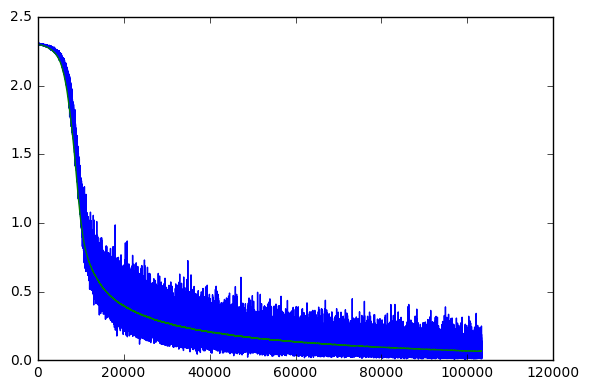

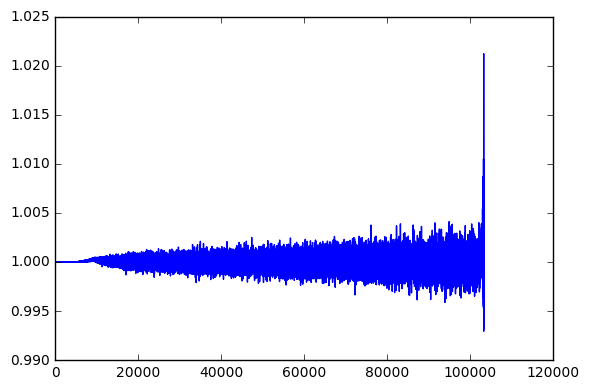

In [14]:
# 2.7 Run training for MAX_STEPS and save checkpoint at the end.
backwards       = False
localMinimum    = False
last_step       = 0
with tf.Session(graph=mnist_graph) as sess:
    # Run the Op to initialize the variables.
    sess.run(init)

    # Start the training loop.
    losses        = []
    avgs          = []
    avgsFolds     = []
    min_seen      = sys.maxint
    min_seen_step = 0
    avg_window    = MAX_STEPS / 100 if MAX_STEPS > 100 else 100
    
    for last_step in xrange(MAX_STEPS+1):
        # Read a batch of images and labels.
        images_feed, labels_feed = data_sets.train.next_batch(BATCH_SIZE)

        # Run one step of the model.  The return values are the activations
        # from the `train_op` (which is discarded) and the `loss` Op.  To
        # inspect the values of your Ops or variables, you may include them
        # in the list passed to sess.run() and the value tensors will be
        # returned in the tuple from the call.
        _, loss_value = sess.run([train_op, loss],
                                 feed_dict={images_placeholder: images_feed,
                                            labels_placeholder: labels_feed})
        
        losses.append(loss_value)
        
        if last_step > avg_window:
            avg      = (sum(losses[-1*avg_window:])*1.0) / avg_window
            avgs.append( avg )
            
            if len(avgs) >= 1:
                if len(avgs) == 1:
                    avgsFolds.append( avgs[-1] / avg )
                else:
                    avgsFolds.append( avgs[-2] / avg )
            
#             avg     *= 2
#             if loss_value > avg:
#                 backwards = True

#         if loss_value < min_seen:
#             min_seen      = loss_value
#             min_seen_step = last_step
            
#         if (last_step > int(MAX_STEPS*0.75)) or backwards:
#             if loss_value <= min_seen:
#                 localMinimum = True
        
        # Print out loss value.
        if (last_step % 1000 == 0) or localMinimum:
            print('Step {:12,d} / {:12,d}: loss = {:6.4f}'.format(last_step, MAX_STEPS, loss_value))

#         if backwards:
#             print "stopped because loss spiked from {:6.4f} to {:6.4f}".format((sum(losses[-1000:])*1.0) / 1000, loss_value)
#             break
        
        if localMinimum:
            pass

    print "loss of {:.6f} at step {:12,d}".format(loss_value, last_step)

    if not localMinimum:
        pass
#         print " higher then the local minimum {:.6f} at step {:12,d}".format(min_seen, min_seen_step)
        
    for p in xrange(-1*avg_window, -100):
        avg = (sum(losses[p:])*1.0) / (p*-1)
        avgs.append( avg )
        avgsFolds.append( avgs[-2] / avg )
    
    plt.plot(losses   )
    plt.plot(avgs     )
    plt.tight_layout()
    plt.show()
    
    plt.plot(avgsFolds)
    plt.tight_layout()
    plt.show()
    
    # Write a checkpoint.
    saver.save(sess, CHECKPOINT_FILE_BN, global_step=MAX_STEPS)

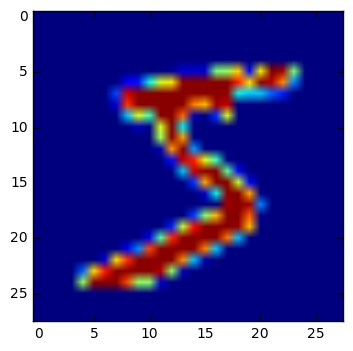

Ground truth: 5
Prediction  : 5


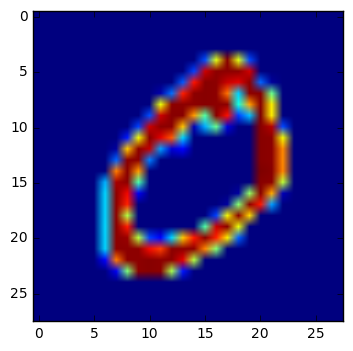

Ground truth: 0
Prediction  : 0


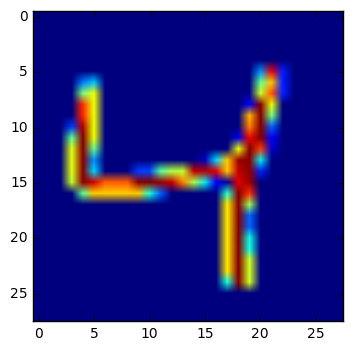

Ground truth: 4
Prediction  : 4


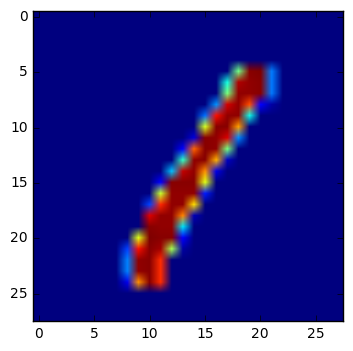

Ground truth: 1
Prediction  : 1


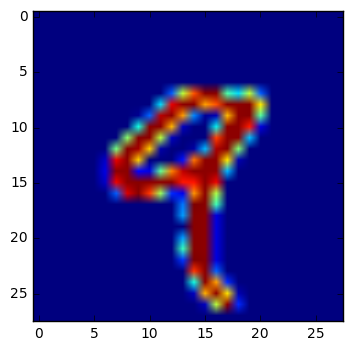

Ground truth: 9
Prediction  : 9


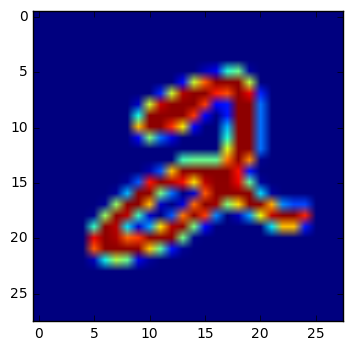

Ground truth: 2
Prediction  : 2


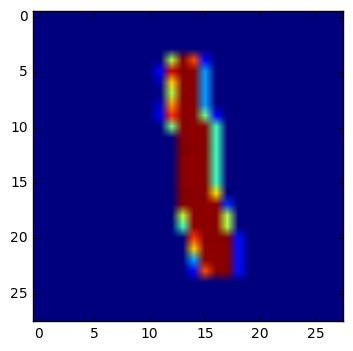

Ground truth: 1
Prediction  : 1


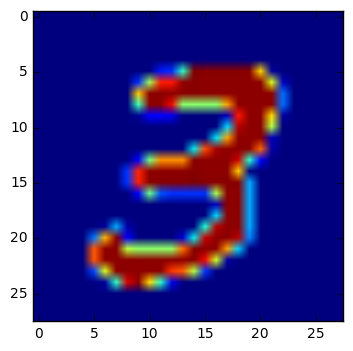

Ground truth: 3
Prediction  : 3


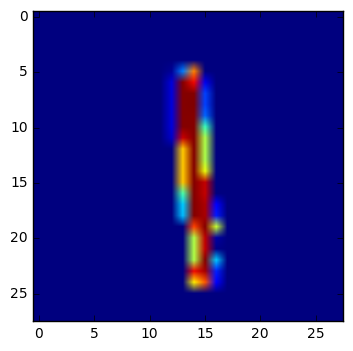

Ground truth: 1
Prediction  : 1


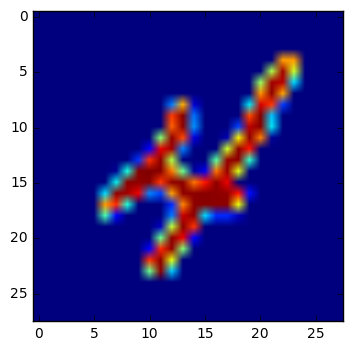

Ground truth: 4
Prediction  : 4


In [15]:
# 2.8 Run evaluation based on the saved checkpoint.
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph( CHECKPOINT_FILE + ".meta")
    
    saver.restore(sess, CHECKPOINT_FILE)

    for cls in xrange(NUM_CLASSES):
        # Retrieve the Ops we 'remembered'.
        logits             = tf.get_collection("logits")[0]
        images_placeholder = tf.get_collection("images")[0]
        labels_placeholder = tf.get_collection("labels")[0]

        # Add an Op that chooses the top k predictions.
        eval_op = tf.nn.top_k(logits)

        # Run evaluation.
        images_feed, labels_feed = data_sets.validation.next_batch(EVAL_BATCH_SIZE)
        if IS_IMAGE:
            imgplot              = plt.imshow(np.reshape(images_feed, DIMENSIONS))
            plt.show()
        prediction = sess.run(eval_op,
                              feed_dict={images_placeholder: images_feed,
                                         labels_placeholder: labels_feed})

        print("Ground truth: %d\nPrediction  : %d" % (labels_feed, prediction.indices[0][0]))
        

In [16]:
# Evaluation on the whole evaluation set.
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph( CHECKPOINT_FILE + ".meta")

    saver.restore(sess, CHECKPOINT_FILE)
    
    print('Validation Data Eval:')
    # And run one epoch of eval.
    true_count         = 0 # Counts the number of correct predictions.
    steps_per_epoch    = data_sets.validation.num_examples
    num_examples       = steps_per_epoch * BATCH_SIZE
    
    # Retrieve the Ops we 'remembered'.
    logits             = tf.get_collection("logits")[0]
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    
    # Add the Op to compare the logits to the labels during evaluation.
    eval_op            = mnist_evaluation(logits, labels_placeholder)
    for step in xrange(steps_per_epoch):
        images_feed, labels_feed  = data_sets.validation.next_batch(BATCH_SIZE)
        true_count               += sess.run(eval_op,
        feed_dict                 = {
                                        images_placeholder: images_feed, 
                                        labels_placeholder: labels_feed
                                    })
        precision                 = true_count * 1.0 / num_examples

    print(' Num examples: {:12,d} Num correct: {:12,d} Precision @ 1: {:6.2f} %'.format(num_examples, true_count, precision*100))

Validation Data Eval:
 Num examples:      500,000 Num correct:      483,000 Precision @ 1:  96.60 %


<p>Back to [1_linear_regression_model.ipynb](1_linear_regression_model.ipynb).</p>
<p>Next to [Bonus Lab](extras/extras_0_deepdream.ipynb).</p>